# Video Action Recognition

In [ ]:
!pip install yt_dlp
!pip install gTTS

In [ ]:
# Moungting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importing libararies
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import random
import datetime as dt
from moviepy.editor import *
from collections import deque
%matplotlib inline
from gtts import gTTS
from sklearn.model_selection import train_test_split
import yt_dlp as youtube_dl
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, ConvLSTM1D, Dropout, Flatten, Input, Attention
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

## Data

In [ ]:
image_height, image_width = 100, 100
max_images = 4000

In [ ]:
data_dir = '/content/drive/MyDrive/ActionRecognition/UCF50'

In [ ]:
categories = os.listdir(data_dir)
print(categories)

['WalkingWithDog', 'SoccerJuggling', 'Swing', 'YoYo', 'VolleyballSpiking', 'TrampolineJumping', 'TennisSwing', 'Skijet', 'ThrowDiscus', 'TaiChi', 'Rowing', 'Skiing', 'RopeClimbing', 'Punch', 'SkateBoarding', 'SalsaSpin', 'PushUps', 'PommelHorse', 'PullUps', 'RockClimbingIndoor', 'Mixing', 'Lunges', 'PoleVault', 'PlayingTabla', 'PizzaTossing', 'PlayingGuitar', 'Nunchucks', 'MilitaryParade', 'PlayingPiano', 'PlayingViolin', 'JugglingBalls', 'HulaHoop', 'JumpRope', 'GolfSwing', 'HighJump', 'Kayaking', 'HorseRiding', 'JumpingJack', 'HorseRace', 'JavelinThrow', 'Fencing', 'BreastStroke', 'Biking', 'CleanAndJerk', 'BenchPress', 'Basketball', 'Billiards', 'Drumming', 'BaseballPitch', 'Diving']


In [ ]:
CLASSES = len(categories)
CLASSES

50

In [ ]:
labels=[i for i in range(len(categories))]
print(labels)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [ ]:
# associating number with the lable of categories
label_dict=dict(zip(categories, labels))
print(label_dict)

{'WalkingWithDog': 0, 'SoccerJuggling': 1, 'Swing': 2, 'YoYo': 3, 'VolleyballSpiking': 4, 'TrampolineJumping': 5, 'TennisSwing': 6, 'Skijet': 7, 'ThrowDiscus': 8, 'TaiChi': 9, 'Rowing': 10, 'Skiing': 11, 'RopeClimbing': 12, 'Punch': 13, 'SkateBoarding': 14, 'SalsaSpin': 15, 'PushUps': 16, 'PommelHorse': 17, 'PullUps': 18, 'RockClimbingIndoor': 19, 'Mixing': 20, 'Lunges': 21, 'PoleVault': 22, 'PlayingTabla': 23, 'PizzaTossing': 24, 'PlayingGuitar': 25, 'Nunchucks': 26, 'MilitaryParade': 27, 'PlayingPiano': 28, 'PlayingViolin': 29, 'JugglingBalls': 30, 'HulaHoop': 31, 'JumpRope': 32, 'GolfSwing': 33, 'HighJump': 34, 'Kayaking': 35, 'HorseRiding': 36, 'JumpingJack': 37, 'HorseRace': 38, 'JavelinThrow': 39, 'Fencing': 40, 'BreastStroke': 41, 'Biking': 42, 'CleanAndJerk': 43, 'BenchPress': 44, 'Basketball': 45, 'Billiards': 46, 'Drumming': 47, 'BaseballPitch': 48, 'Diving': 49}


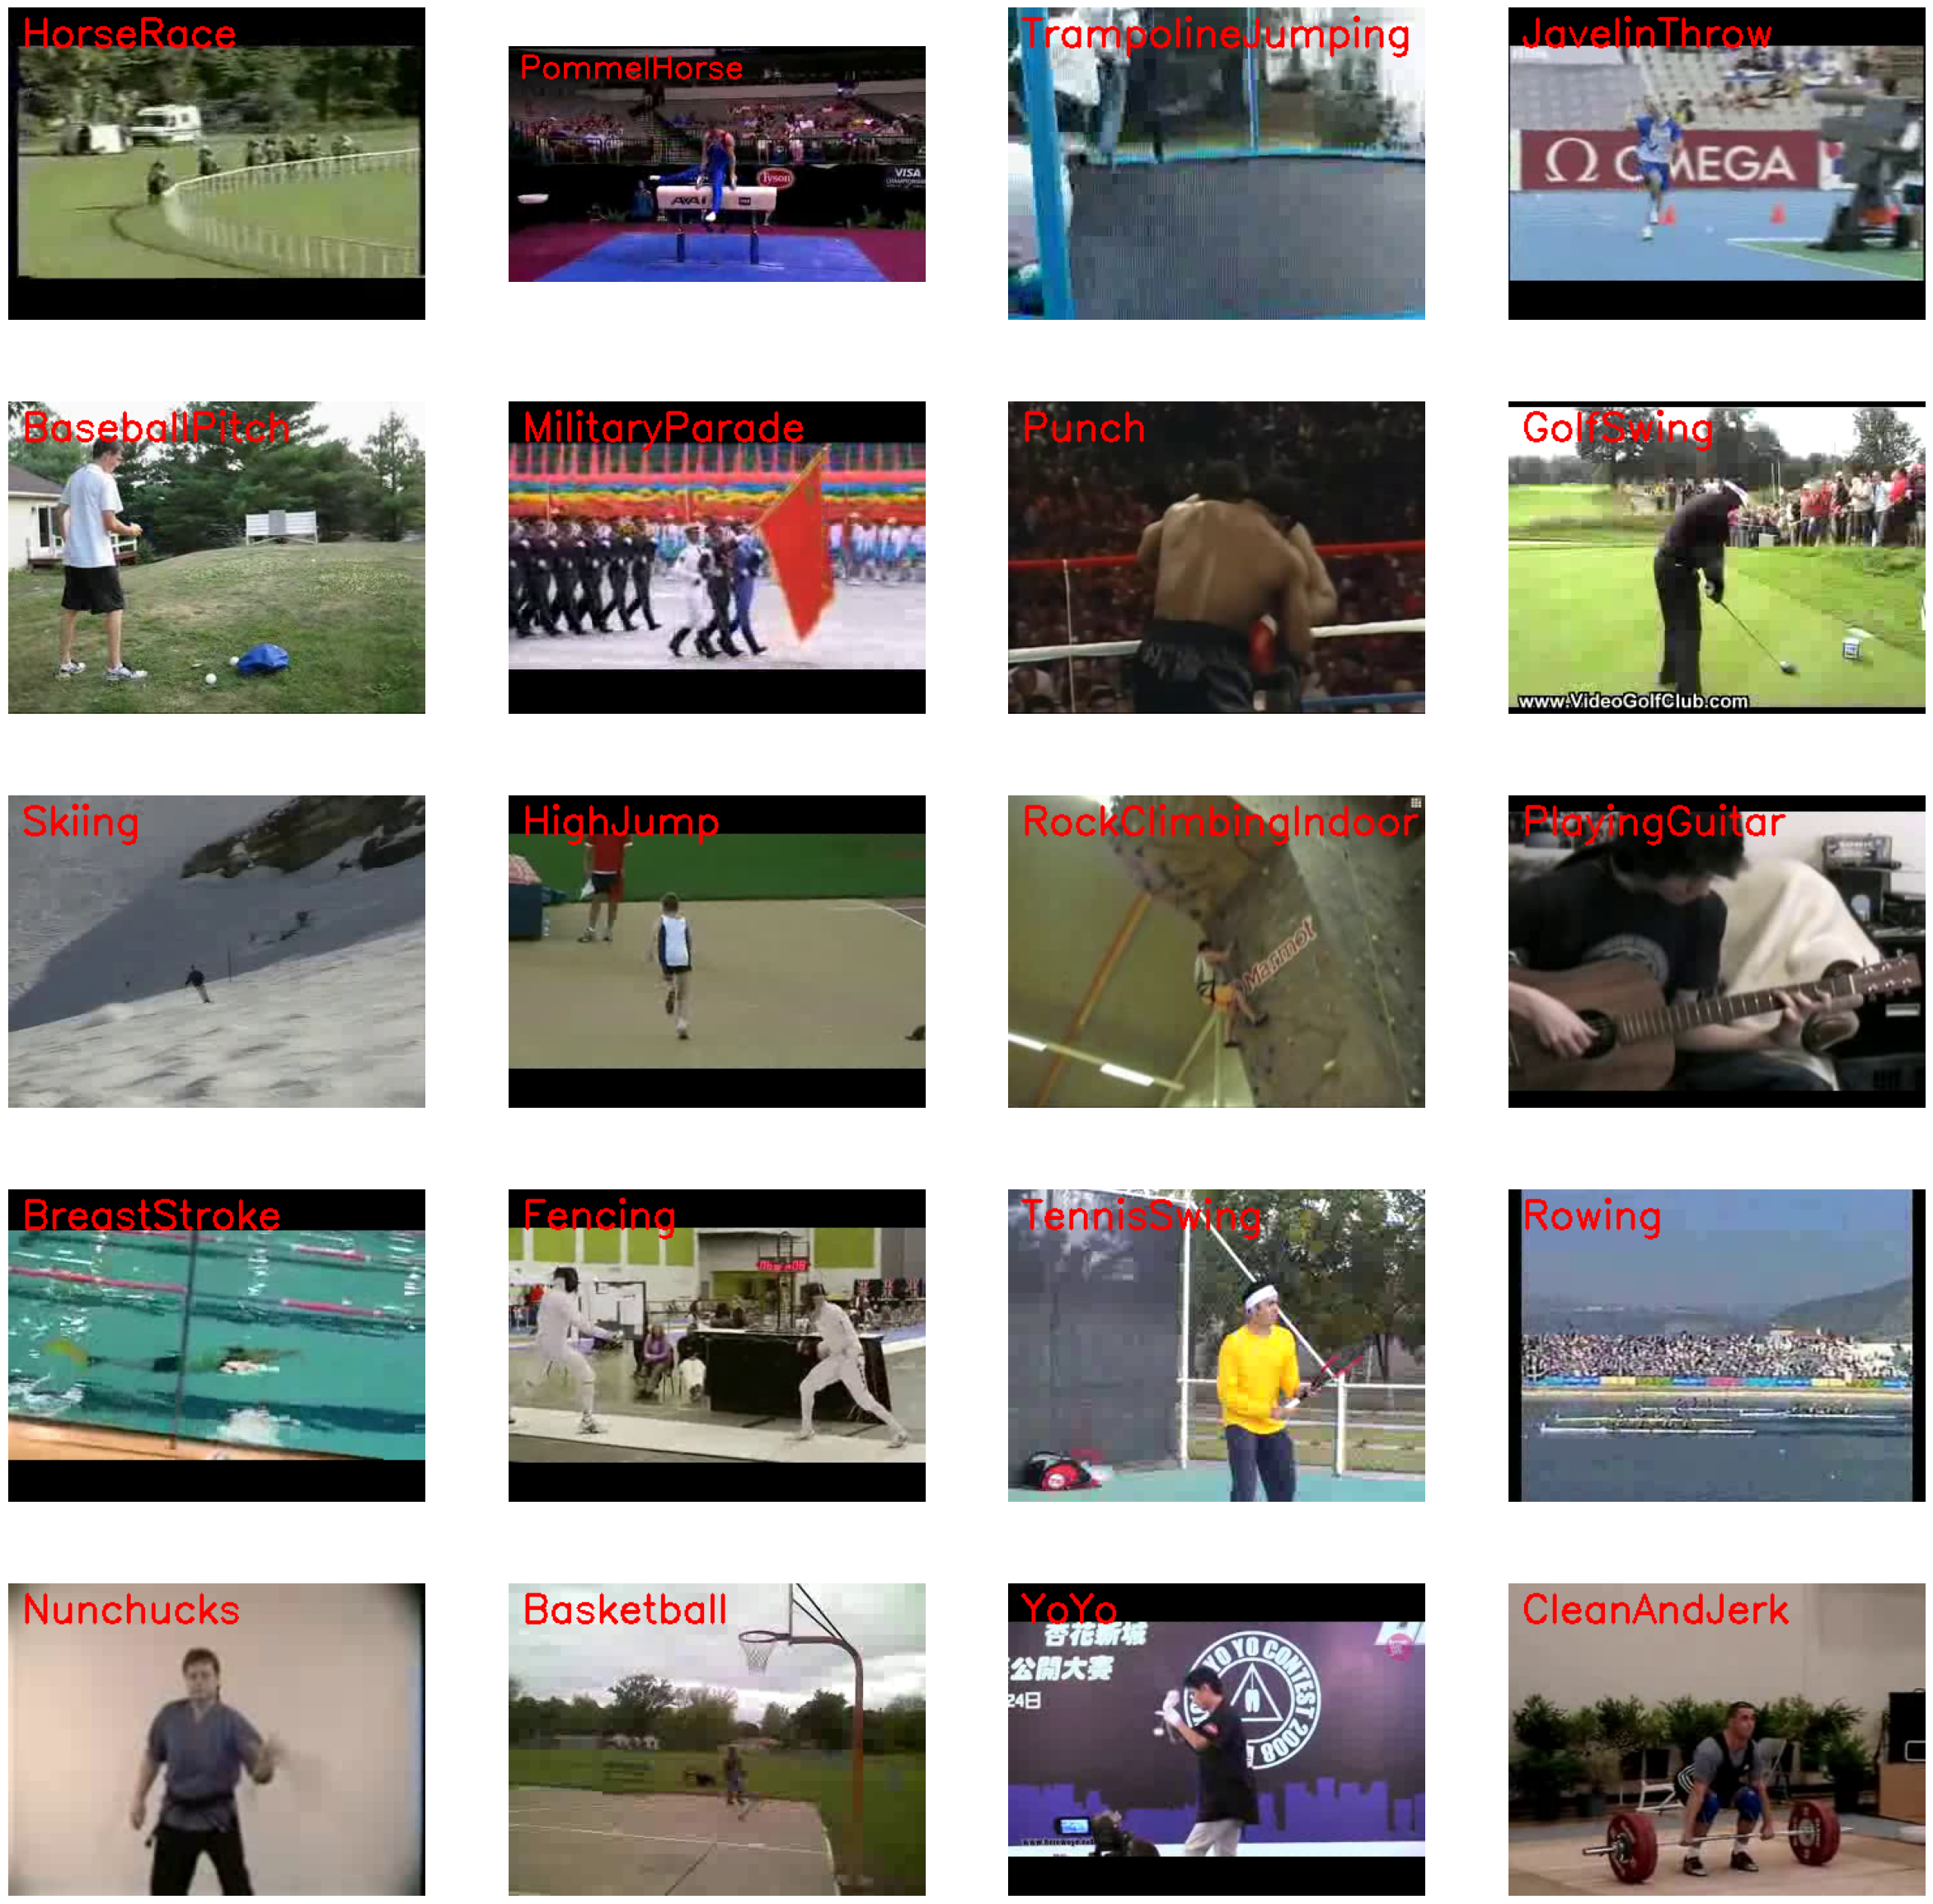

In [ ]:
plt.figure(figsize = (30, 30))
randRange = random.sample(range(len(categories)), 20)

for counter, idx in enumerate(randRange, 1):

    clas = categories[idx]
    video_list = os.listdir(f'{data_dir}/{clas}')
    video = random.choice(video_list)
    video_reader = cv2.VideoCapture(f'{data_dir}/{clas}/{video}')
    _, bgr_frame = video_reader.read()
    video_reader.release()
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, clas, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

In [ ]:
# taking as sample of classes due to memory run out
class_list = ["HorseRace", "WalkingWithDog", "Swing", "TaiChi"]
classes = len(class_list)

In [ ]:
# getting the video frames as an image and normalising the data
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    while True:
        ret, frame = video_reader.read()
        if not ret:
            break
        resized_frame = cv2.resize(frame, (image_height, image_width))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    video_reader.release()
    return frames_list

In [ ]:
# Generating data by reading each vidoe file in the category and extracting the features
def genrateData():
    feat = []
    features = []
    labels = []
    for class_index, class_name in enumerate(class_list):
        print(f'Generating Data for Class: {class_name}')
        files_list = os.listdir(os.path.join(data_dir, class_name))
        for file_name in files_list:
            path = os.path.join(data_dir, class_name, file_name)
            frames = frames_extraction(path)
            feat.extend(frames)
        features.extend(random.sample(feat, max_images))
        labels.extend([class_index] * max_images)
        feat.clear()
    features = np.asarray(features)
    labels = np.array(labels)
    return features, labels

In [ ]:
# generating the data
features, labels = genrateData()

Generating Data for Class: HorseRace
Generating Data for Class: WalkingWithDog
Generating Data for Class: Swing
Generating Data for Class: TaiChi


In [ ]:
# converting target to categirocal so the neural network models can read target in
target = to_categorical(labels)

In [ ]:
#diving features and taget into traing and testing set
features_train, features_test, labels_train, labels_test = train_test_split(features, target, test_size=0.2, random_state =246)

# CNN

In [ ]:
# building CNN model
cnn = Sequential()
cnn.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
cnn.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(GlobalAveragePooling2D())
cnn.add(Dense(256, activation = 'relu'))
cnn.add(BatchNormalization())
cnn.add(Dense(classes, activation = 'softmax'))
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                        

In [ ]:
# model training
cnn.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
history = cnn.fit(x = features_train, y = labels_train, epochs = 10, validation_split = 0.2)

Epoch 1/10
320/320 [==============================] - 131s 404ms/step - loss: 0.6347 - accuracy: 0.7552 - val_loss: 1.4535 - val_accuracy: 0.3613
Epoch 2/10
320/320 [==============================] - 128s 401ms/step - loss: 0.2956 - accuracy: 0.9016 - val_loss: 0.5700 - val_accuracy: 0.7523
Epoch 3/10
320/320 [==============================] - 128s 399ms/step - loss: 0.1913 - accuracy: 0.9385 - val_loss: 0.6726 - val_accuracy: 0.7992
Epoch 4/10
320/320 [==============================] - 127s 398ms/step - loss: 0.1407 - accuracy: 0.9523 - val_loss: 0.9795 - val_accuracy: 0.7355
Epoch 5/10
320/320 [==============================] - 127s 398ms/step - loss: 0.1147 - accuracy: 0.9615 - val_loss: 1.3257 - val_accuracy: 0.6449
Epoch 6/10
320/320 [==============================] - 127s 397ms/step - loss: 0.0978 - accuracy: 0.9666 - val_loss: 3.0387 - val_accuracy: 0.5531
Epoch 7/10
320/320 [==============================] - 128s 399ms/step - loss: 0.0866 - accuracy: 0.9729 - val_loss: 0.7846 -

In [ ]:
# plot for each epch on loss and accuracy
def plot_metric(metric_name_1, metric_name_2, plot_name):
    metric_value_1 = history.history[metric_name_1]
    metric_value_2 = history.history[metric_name_2]
    epochs = range(len(metric_value_1))
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
    plt.title(str(plot_name))
    plt.legend()

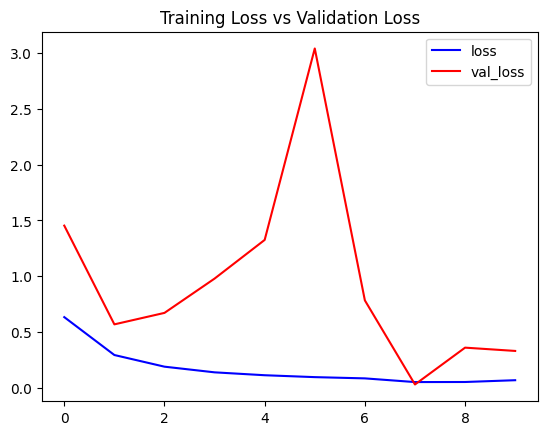

In [ ]:
# training loss plt
plot_metric('loss', 'val_loss', 'Training Loss vs Validation Loss')

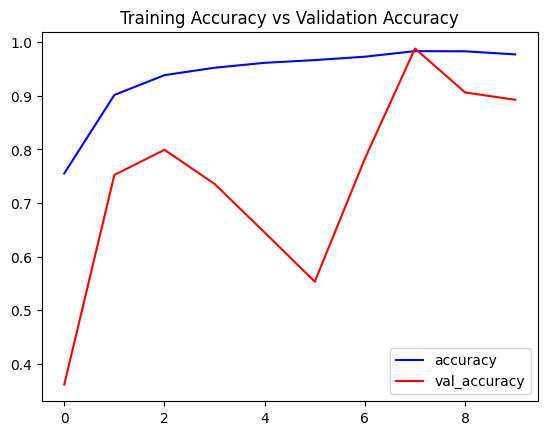

In [ ]:
# training accuracy plot for each epoch
plot_metric('accuracy', 'val_accuracy', 'Training Accuracy vs Validation Accuracy')

In [ ]:
# testing the model accuracy score
cnn.evaluate(features_test, labels_test)

100/100 [==============================] - 5s 51ms/step - loss: 0.3235 - accuracy: 0.8869


[0.3235349953174591, 0.8868749737739563]

#  LSTM

In [ ]:
lstm = Sequential()
lstm.add(ConvLSTM1D(filters = 64, kernel_size = (1), activation = 'relu', input_shape = (image_height, image_width, 3)))
lstm.add(Dropout(0.1))
lstm.add(Flatten())
lstm.add(Dense(classes, activation='sigmoid'))

In [ ]:
lstm.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
history = lstm.fit(x = features_train, y = labels_train, epochs = 10, validation_split = 0.2)

Epoch 1/10
320/320 [==============================] - 107s 327ms/step - loss: 66.9137 - accuracy: 0.4645 - val_loss: 1.1479 - val_accuracy: 0.4891
Epoch 2/10
320/320 [==============================] - 101s 317ms/step - loss: 1.2176 - accuracy: 0.5147 - val_loss: 1.0837 - val_accuracy: 0.5340
Epoch 3/10
320/320 [==============================] - 101s 315ms/step - loss: 1330447.0000 - accuracy: 0.4998 - val_loss: 1.1204 - val_accuracy: 0.5277
Epoch 4/10
320/320 [==============================] - 100s 313ms/step - loss: 1.0867 - accuracy: 0.5324 - val_loss: 1.0649 - val_accuracy: 0.5629
Epoch 5/10
320/320 [==============================] - 101s 317ms/step - loss: 1.0535 - accuracy: 0.5495 - val_loss: 1.0444 - val_accuracy: 0.5461
Epoch 6/10
320/320 [==============================] - 100s 314ms/step - loss: 6956902.5000 - accuracy: 0.4946 - val_loss: 5.8592 - val_accuracy: 0.4859
Epoch 7/10
320/320 [==============================] - 100s 314ms/step - loss: 6.6399 - accuracy: 0.5172 - val_l

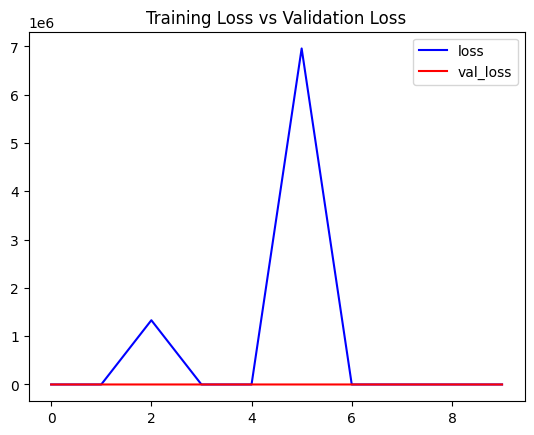

In [ ]:
plot_metric('loss', 'val_loss', 'Training Loss vs Validation Loss')

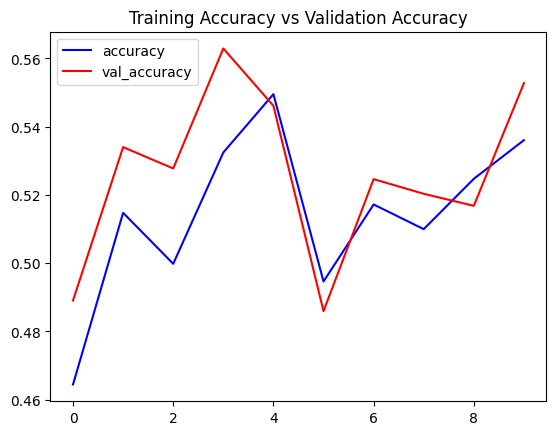

In [ ]:
plot_metric('accuracy', 'val_accuracy', 'Training Accuracy vs Validation Accuracy')

In [ ]:
lstm.evaluate(features_test, labels_test)

100/100 [==============================] - 10s 104ms/step - loss: 3.1159 - accuracy: 0.5578


[3.115891933441162, 0.557812511920929]

#  Attention LSTM

In [ ]:
x=Input(shape=(image_height, image_width, 3))
LSTMlayer = ConvLSTM1D(filters = 3, kernel_size = (1), activation = 'relu')(x)
dropout = Dropout(0.2)(LSTMlayer)
attention_layer = Attention(score_mode="dot")([dropout, LSTMlayer])
flatten = Flatten()(attention_layer)
outputs=Dense(classes, activation="softmax")(flatten)
attenLSTM=Model(x,outputs)

In [ ]:
attenLSTM.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
history = attenLSTM.fit(x = features_train, y = labels_train, epochs = 10, validation_split = 0.2)

Epoch 1/10
320/320 [==============================] - 31s 85ms/step - loss: 1.2771 - accuracy: 0.3995 - val_loss: 1.2281 - val_accuracy: 0.4453
Epoch 2/10
320/320 [==============================] - 26s 81ms/step - loss: 1.2011 - accuracy: 0.4462 - val_loss: 1.2044 - val_accuracy: 0.4289
Epoch 3/10
320/320 [==============================] - 27s 85ms/step - loss: 1.1799 - accuracy: 0.4486 - val_loss: 1.2078 - val_accuracy: 0.4523
Epoch 4/10
320/320 [==============================] - 25s 79ms/step - loss: 1.1677 - accuracy: 0.4434 - val_loss: 1.1792 - val_accuracy: 0.4422
Epoch 5/10
320/320 [==============================] - 25s 79ms/step - loss: 1.1548 - accuracy: 0.4489 - val_loss: 1.1680 - val_accuracy: 0.4410
Epoch 6/10
320/320 [==============================] - 25s 78ms/step - loss: 1.1432 - accuracy: 0.4471 - val_loss: 1.1711 - val_accuracy: 0.4273
Epoch 7/10
320/320 [==============================] - 25s 78ms/step - loss: 1.1371 - accuracy: 0.4468 - val_loss: 1.1477 - val_accuracy:

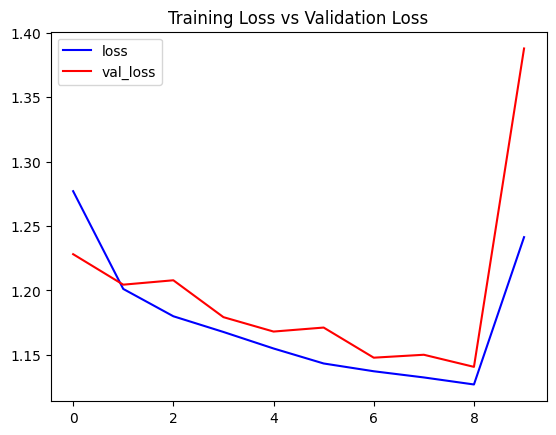

In [ ]:
plot_metric('loss', 'val_loss', 'Training Loss vs Validation Loss')

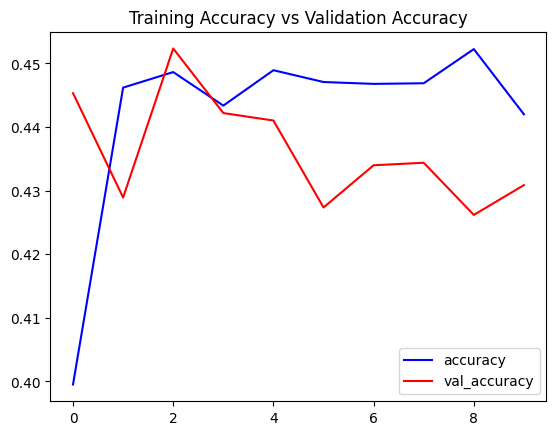

In [ ]:
plot_metric('accuracy', 'val_accuracy', 'Training Accuracy vs Validation Accuracy')

In [ ]:
attenLSTM.evaluate(features_test, labels_test)

100/100 [==============================] - 2s 17ms/step - loss: 1.3764 - accuracy: 0.4384


[1.3764348030090332, 0.43843749165534973]

# Validate

In [ ]:
def download_youtube_videos(url, name):
    output_dir = '/content/drive/MyDrive/ActionRecognition/Youtube_Videos'  # path to save downloaded video
    os.makedirs(output_dir, exist_ok = True)
    ydl_opts={
      'format': 'best',
      'outtmpl': f'{output_dir}/{name}'+'.mp4',   # name for video and path
    }
    with youtube_dl.YoutubeDL(ydl_opts) as ydl:  # to download youtube video
        ydl.download([url])

In [ ]:
audio_text=[]

# reading youtuve video examining ecah frame nad predicting the action in the frame using CNN as that was best performing model
def videoActionRecognition(video_file_path, output_file_path, window_size):
    predProbabDeque = deque(maxlen = window_size)
    video_reader = cv2.VideoCapture(video_file_path)
    video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 28, (video_width, video_height))
    while True:
        ret, frame = video_reader.read()
        if not ret:
            break
        frame1 = cv2.resize(frame, (image_height, image_width))
        frame1 = frame1 / 255
        predProbabilty = cnn.predict(np.expand_dims(frame1, axis = 0))[0]
        predProbabDeque.append(predProbabilty)
        if len(predProbabDeque) == window_size:
            predProbabilty = np.array(predProbabDeque)
            predProbabilty_avg = predProbabilty.mean(axis = 0)
            predicted_label = np.argmax(predProbabilty_avg)
            predicted_class = class_list[predicted_label]
            cv2.putText(frame, predicted_class, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            audio_text.append(predicted_class)   # making list for category class so we can genrate audio for the action
        video_writer.write(frame)
    video_reader.release()
    video_writer.release()

In [ ]:
window_size = 1
output_dir = '/content/drive/MyDrive/ActionRecognition/Youtube_Videos'
os.makedirs(output_dir, exist_ok = True)  # making directory if it doesnt exist

In [ ]:
video_title = download_youtube_videos('https://www.youtube.com/watch?v=WHBu6iePxKc', 'video1')
output_path = f'{output_dir}/Pred1-WSize{window_size}.mp4'   # genrating path for prediction video
videoActionRecognition(f'{output_dir}/video1.mp4', output_path, window_size)   # making video for prediction of action

[youtube] Extracting URL: https://www.youtube.com/watch?v=WHBu6iePxKc
[youtube] WHBu6iePxKc: Downloading webpage
[youtube] WHBu6iePxKc: Downloading ios player API JSON
[youtube] WHBu6iePxKc: Downloading android player API JSON
[youtube] WHBu6iePxKc: Downloading m3u8 information
[info] WHBu6iePxKc: Downloading 1 format(s): 22
[download] /content/drive/MyDrive/ActionRecognition/Youtube_Videos/video1.mp4 has already been downloaded
[download] 100% of   14.61MiB
1/1 [==============================] - 0s 23ms/step


In [ ]:
audio_text = ' '.join(audio_text)  # converting audio text list to string
print(audio_text)

Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swing Swin

In [ ]:
obj = gTTS(text=audio_text, lang='en', slow=False)   # generating speech for audio text and saving it
obj.save(f"{output_dir}/audio.mp3")

In [ ]:
videoclip = VideoFileClip(output_path)   # adding audio for predicted action to the video
audioclip = AudioFileClip(f"{output_dir}/audio.mp3")

new_audioclip = CompositeAudioClip([audioclip])
videoclip.audio = new_audioclip
videoclip.write_videofile(f"{output_dir}/PredictionOutput.mp4")

Moviepy - Building video /content/drive/MyDrive/ActionRecognition/Youtube_Videos/PredictionOutput.mp4.
MoviePy - Writing audio in PredictionOutputTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/ActionRecognition/Youtube_Videos/PredictionOutput.mp4



t: 100%|█████████▉| 1648/1652 [00:11<00:00, 141.35it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/ActionRecognition/Youtube_Videos/Pred1-WSize1.mp4, 2764800 bytes wanted but 0 bytes read,at frame 1651/1652, at time 58.96/58.97 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/ActionRecognition/Youtube_Videos/PredictionOutput.mp4


In [ ]:
audio_text=[]
video_title = download_youtube_videos('https://www.youtube.com/watch?v=8u0qjmHIOcE',  'video2')
output_path = f'{output_dir}/Pred2-WSize{window_size}.mp4'
videoActionRecognition(f'{output_dir}/video2.mp4', output_path, window_size)
audio_text = ' '.join(audio_text)

[youtube] Extracting URL: https://www.youtube.com/watch?v=8u0qjmHIOcE
[youtube] 8u0qjmHIOcE: Downloading webpage
[youtube] 8u0qjmHIOcE: Downloading ios player API JSON
[youtube] 8u0qjmHIOcE: Downloading android player API JSON
[youtube] 8u0qjmHIOcE: Downloading m3u8 information
[info] 8u0qjmHIOcE: Downloading 1 format(s): 18
[download] /content/drive/MyDrive/ActionRecognition/Youtube_Videos/video2.mp4 has already been downloaded
[download] 100% of    1.10MiB
1/1 [==============================] - 0s 22ms/step


In [ ]:
obj = gTTS(text=audio_text, lang='en', slow=False)
obj.save(f"{output_dir}/audio2.mp3")
videoclip = VideoFileClip(output_path)
audioclip = AudioFileClip(f"{output_dir}/audio2.mp3")

new_audioclip = CompositeAudioClip([audioclip])
videoclip.audio = new_audioclip
videoclip.write_videofile(f"{output_dir}/PredictionOutput2.mp4")
VideoFileClip(output_path).ipython_display(width = 700)

Moviepy - Building video /content/drive/MyDrive/ActionRecognition/Youtube_Videos/PredictionOutput2.mp4.
MoviePy - Writing audio in PredictionOutput2TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/ActionRecognition/Youtube_Videos/PredictionOutput2.mp4



t:  99%|█████████▉| 862/867 [00:01<00:00, 686.53it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/ActionRecognition/Youtube_Videos/Pred2-WSize1.mp4, 230400 bytes wanted but 0 bytes read,at frame 866/867, at time 30.93/30.93 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/ActionRecognition/Youtube_Videos/PredictionOutput2.mp4
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
